#### notebook Eksperimental 

- bertujuan untuk membangun ML untuk prediski Item Belanja dari hasil OCR

In [38]:
# data
import pandas as pd
import numpy as np
import joblib

# regex & util
import re

# sklearn core
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# misc
from pathlib import Path


### Load Dataset CSV (hasil labeling)

In [2]:
dataPath = Path("output")  # sesuaikan
csvPath = dataPath / "ocr_lines.csv"

df = pd.read_csv(csvPath)

df.head()


,receipt_id,line_id,text,ocr_conf,x_min,y_min,x_max,y_max,x_center_norm,y_center_norm,box_width_norm,has_digit,text_len,is_item_line
0,receipt_001,0,APOTEKKU,0.9957,323,209,679,279,0.521875,0.190625,0.370833,0,8,0.0
1,receipt_001,1,APOTEKKU GUNUNG SANGHYANG,0.9941,104,289,596,327,0.364583,0.240625,0.512500,0,25,0.0
2,receipt_001,2,JL.,0.8787,104,326,170,354,0.142708,0.265625,0.068750,0,3,0.0
3,receipt_001,3,"GRUNUNG SANGHYANG NO, 270, KEROBOKAN",0.9671,181,317,851,357,0.537500,0.263281,0.697917,1,36,0.0
4,receipt_001,4,KAJA,0.9852,96,352,195,384,0.151562,0.287500,0.103125,0,4,0.0


In [ ]:
# Dataset ini yang akan diguabn
csv_New = dataPath / "ocr_lines2.csv"

df_new = pd.read_csv(csv_New)

df_new.head()

,receipt_id,line_id,text,ocr_conf,x_min,y_min,x_max,y_max,x_center_norm,y_center_norm,box_width_norm,has_digit,text_len,is_item_line
0,receipt_023,0,MEGA ARTA,0.9618,2273,1173,3710,1424,0.488807,0.159130,0.234804,0,9,0
1,receipt_023,1,J7. Tangkuban Perahu,0.9506,1487,1387,4517,1747,0.490523,0.192034,0.495098,1,20,0
2,receipt_023,2,Padangsambian - Denpasar,0.9876,1208,1670,4816,1987,0.492157,0.224081,0.589542,0,24,0
3,receipt_023,3,16/12/2025,0.9998,2560,2576,3894,2860,0.527288,0.333088,0.217974,1,10,0
4,receipt_023,4,Date,0.9996,742,2608,1409,2867,0.175735,0.335478,0.108987,0,4,0


### Validasi Dataset

In [6]:
print(df.shape)
print(df.columns)
print(df["is_item_line"].value_counts())


(804, 14)
Index(['receipt_id', 'line_id', 'text', 'ocr_conf', 'x_min', 'y_min', 'x_max',
       'y_max', 'x_center_norm', 'y_center_norm', 'box_width_norm',
       'has_digit', 'text_len', 'is_item_line'],
      dtype='object')
is_item_line
0.0    468
1.0    332
Name: count, dtype: int64


In [7]:
print(df_new.shape)
print(df_new.columns)
print(df_new["is_item_line"].value_counts())

(877, 14)
Index(['receipt_id', 'line_id', 'text', 'ocr_conf', 'x_min', 'y_min', 'x_max',
       'y_max', 'x_center_norm', 'y_center_norm', 'box_width_norm',
       'has_digit', 'text_len', 'is_item_line'],
      dtype='object')
is_item_line
0    683
1    194
Name: count, dtype: int64


In [24]:
# Check jika ada baris yang belum di lebeli
# label baris adalah binary untuk memberikan tanda bahwa baris tersebut adalah item belanjaan.

if "is_item_line" not in df.columns:
    df["is_item_line"] = pd.NA

print("Belum dilabeli:", df["is_item_line"].isna().sum())

Belum dilabeli: 4


In [25]:
# Jalankan ini jika ada baris yang belum di lebel dan 
# PASTIKAN bahwa baris tersebut adalah non item 
# 0 ADALAH NON ITEM DAN 1 ITEM BELANJAAN

df.loc[df["is_item_line"].isna(), "is_item_line"] = 0


In [26]:
# URUTKAN DATASET BERDASARKA STRUK ID DAN POSIS BARIS, 
# Y_CENTER_NORM UNTUK VERTIKAL DAN X_CENTER_NORM UNTUK HORIZONTAL.

df = df.sort_values(
    by=["receipt_id", "y_center_norm", "x_center_norm"]
).reset_index(drop=True)


In [8]:
# URUTKAN DATASET BERDASARKA STRUK ID DAN POSIS BARIS, 
# Y_CENTER_NORM UNTUK VERTIKAL DAN X_CENTER_NORM UNTUK HORIZONTAL.

df_new = df_new.sort_values(
    by=["receipt_id", "y_center_norm", "x_center_norm"]
).reset_index(drop=True)

### Feature Engineering Helper Functions

In [18]:

price_regex = re.compile(r"\d+[.,]\d+") 

def has_price_pattern(text):
    """
    Mengecek keberadaan pola angka yang menyerupai format harga atau nominal.
    
    Fungsi ini mencari angka yang diikuti oleh separator (titik atau koma) 
    dan diakhiri oleh tepat 2 atau 3 digit (contoh: '10.500' atau '99,99').
    
    Args:
        text (str): String input yang akan diperiksa.
        
    Returns:
        bool: True jika pola ditemukan, False jika tidak.
    """
    if not isinstance(text, str):
        return 0
    return int(bool(price_regex.search(text)))


def has_qty_pattern(text):
    """
    Mengecek keberadaan pola kuantitas atau dimensi dalam string.
    
    Fungsi ini mendeteksi pola format "angka x angka" atau "angka @ angka" 
    secara case-insensitive (huruf besar/kecil tidak berpengaruh).
    
    Args:
        text (str): String input yang akan diperiksa.
        
    Returns:
        bool: True jika pola ditemukan, False jika tidak.
    """
    qty_regex = re.compile(r"(\b\d+\s*[xX@]\s*\d+\b)|(\b\d+\s*[xX]\b)")

    if not isinstance(text, str):
        return 0
    return int(bool(qty_regex.search(text)))


def digit_ratio(text):
    """
    Menghitung densitas angka dalam sebuah string.
    
    Nilai dihitung berdasarkan jumlah digit dibagi dengan total panjang 
    karakter dalam teks (termasuk spasi, tanda baca, dll).
    
    Args:
        text (str): String input yang akan dianalisis.
        
    Returns:
        float: Nilai rasio antara 0.0 hingga 1.0.
               Mengembalikan 0 jika string kosong (empty string).
    """
    if not isinstance(text, str) or len(text) == 0:
        return 0.0
    return sum(c.isdigit() for c in text) / len(text)

 
def upper_ratio(text):
    """
    Menghitung rasio penggunaan huruf kapital dalam sebuah string.
    
    Fungsi ini menyaring karakter non-alfabet (angka, spasi, simbol) sebelum 
    melakukan perhitungan.
    
    Args:
        text (str): String input yang akan dianalisis.
        
    Returns:
        float: Nilai rasio antara 0.0 hingga 1.0. 
               Mengembalikan 0 jika tidak ditemukan huruf sama sekali.
    """
    if not isinstance(text, str) or len(text) == 0:
        return 0.0
    letters = [c for c in text if c.isalpha()]
    if not letters:
        return 0.0
    return sum(c.isupper() for c in letters) / len(letters)


def contains_keywords(text, keywords):
    """
    Mendeteksi keberadaan kata kunci tertentu dalam teks sebagai fitur biner.
    
    Pencarian dilakukan secara case-insensitive. Fungsi mengembalikan integer
    agar dapat langsung digunakan sebagai input numerik untuk model ML.
    
    Args:
        text (str): String input yang akan diperiksa.
        keywords (list of str): Daftar kata kunci yang dicari.
        
    Returns:
        int: 1 jika minimal satu keyword ditemukan, 0 jika tidak ada sama sekali.
    """
    if not isinstance(text, str):
        return 0
    text = text.lower()
    return int(any(k in text for k in keywords))


In [19]:
def build_features(df):
    """
    Membangun dataset fitur (feature engineering) dari data mentah OCR.
    
    Fungsi ini menggabungkan fitur spasial (posisi), kontekstual (jarak antar baris), 
    statistik teks, dan sinyal semantik (keyword) ke dalam satu DataFrame.

    Tujuan dari fungsi ini adalah untuk mengklasifikasikan apakah text dari hasil ocr
    bagian dari item belanjaan atau tidak 
    
    Args:
        df (pd.DataFrame): DataFrame input yang WAJIB memiliki kolom:
            - 'receipt_id': ID unik untuk setiap struk.
            - 'text': String hasil pembacaan OCR.
            - 'x_center_norm': Posisi horizontal ternormalisasi.
            - 'y_center_norm': Posisi vertikal ternormalisasi.
            - 'y': Posisi vertikal (untuk perhitungan diff/jarak).
            
    Returns:
        pd.DataFrame: DataFrame baru yang berisi kolom-kolom fitur numerik
                      siap pakai untuk pelatihan model ML.
    """
    
    feats = pd.DataFrame()

    # posisi
    feats["x"] = df["x_center_norm"]
    feats["y"] = df["y_center_norm"]

    # dy prev / next
    feats["dy_prev"] = df.groupby("receipt_id")["y_center_norm"].diff().fillna(0)
    feats["dy_next"] = df.groupby("receipt_id")["y_center_norm"].diff(-1).fillna(0).abs()

    # text stats
    feats["text_len"] = df["text"].str.len()
    feats["digit_ratio"] = df["text"].apply(digit_ratio)
    feats["upper_ratio"] = df["text"].apply(upper_ratio)

    # regex flags
    feats["has_price"] = df["text"].apply(has_price_pattern).astype(int)
    feats["has_qty"] = df["text"].apply(has_qty_pattern).astype(int)

    # keyword hints (soft signal)
    feats["kw_total"] = df["text"].apply(
        lambda x: contains_keywords(x, ["total", "subtotal", "grand total", "total belanja",])
    )
    feats["kw_cash"] = df["text"].apply(
        lambda x: contains_keywords(x, ["cash", "tunai", "qris", "pembayaran",])
    )
    feats["kw_disc"] = df["text"].apply(
        lambda x: contains_keywords(x, ["disc", "ppn", "bkp",])
    )

    return feats


In [ ]:
# buil feature untuk dataset 
X = build_features(df)
y = df["is_item_line"].astype(int)

X.head()


,x,y,dy_prev,dy_next,text_len,digit_ratio,upper_ratio,has_price,has_qty,kw_total,kw_cash,kw_disc
0,0.521875,0.190625,0.000000,0.050000,8,0.000000,1.0,0,0,0,0,0
1,0.364583,0.240625,0.050000,0.022656,25,0.000000,1.0,0,0,0,0,0
2,0.537500,0.263281,0.022656,0.002344,36,0.083333,1.0,0,0,0,0,0
3,0.142708,0.265625,0.002344,0.021875,3,0.000000,1.0,0,0,0,0,0
4,0.151562,0.287500,0.021875,0.023438,4,0.000000,1.0,0,0,0,0,0


In [ ]:
# build feature untuk dataset baru untuk validasi.
X_new = build_features(df_new)
y_new = df_new["is_item_line"].astype(int)

X_new.head()


,x,y,dy_prev,dy_next,text_len,digit_ratio,upper_ratio,has_price,has_qty,kw_total,kw_cash,kw_disc
0,0.488807,0.159130,0.000000,0.032904,9.0,0.00,1.000000,0,0,0,0,0
1,0.490523,0.192034,0.032904,0.032047,20.0,0.05,0.187500,0,0,0,0,0
2,0.492157,0.224081,0.032047,0.109007,24.0,0.00,0.095238,0,0,0,0,0
3,0.527288,0.333088,0.109007,0.002022,10.0,0.80,0.000000,0,0,0,0,0
4,0.762255,0.335110,0.002022,0.000368,8.0,0.75,0.000000,0,0,0,0,0


### Train/Test Split (PER RECEIPT)

In [ ]:
# Train split ini hanya untuk dataset df / dataset satu.
receipt_ids = df["receipt_id"].unique()

train_ids, test_ids = train_test_split(
    receipt_ids,
    test_size=0.2,
    random_state=42
)

train_mask = df["receipt_id"].isin(train_ids)
test_mask = df["receipt_id"].isin(test_ids)

x_train, x_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]


### Model 1: Logistic Regression (Baseline)

In [29]:
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

lr_pipeline.fit(x_train, y_train)

y_pred_lr = lr_pipeline.predict(x_test)

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr, digits=3))


Logistic Regression
              precision    recall  f1-score   support

           0      0.869     0.689     0.768       106
           1      0.312     0.577     0.405        26

    accuracy                          0.667       132
   macro avg      0.591     0.633     0.587       132
weighted avg      0.759     0.667     0.697       132



### Model 2: Random Forest

In [30]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(x_train, y_train)

y_pred_rf = rf_model.predict(x_test)

print("Random Forest")
print(classification_report(y_test, y_pred_rf, digits=3))


Random Forest
              precision    recall  f1-score   support

           0      0.948     0.868     0.906       106
           1      0.600     0.808     0.689        26

    accuracy                          0.856       132
   macro avg      0.774     0.838     0.797       132
weighted avg      0.880     0.856     0.863       132



In [31]:
def fn_per_receipt(y_true, y_pred, receipts):
    df_eval = pd.DataFrame({
        "receipt_id": receipts,
        "y_true": y_true,
        "y_pred": y_pred
    })
    fn = df_eval[(df_eval.y_true == 1) & (df_eval.y_pred == 0)]
    return fn.groupby("receipt_id").size().mean()

print("FN / receipt (LR):", fn_per_receipt(y_test, y_pred_lr, df.loc[test_mask, "receipt_id"]))
print("FN / receipt (RF):", fn_per_receipt(y_test, y_pred_rf, df.loc[test_mask, "receipt_id"]))


FN / receipt (LR): 2.75
FN / receipt (RF): 1.6666666666666667


#### Validasi Model Random Forest dengan dataset baru 

In [35]:
y_pred_new = rf_model.predict(X_new)

print(classification_report(y_new, y_pred_new, digits=3))
print("FN / receipt:",
      fn_per_receipt(y_new, y_pred_new, df_new["receipt_id"]))

              precision    recall  f1-score   support

           0      0.963     0.801     0.875       683
           1      0.560     0.892     0.688       194

    accuracy                          0.821       877
   macro avg      0.761     0.846     0.781       877
weighted avg      0.874     0.821     0.833       877

FN / receipt: 1.5


##### Interpretasi paling penting (bukan accuracy)

* Recall ITEM (INI KPI UTAMA)

* Naik dari ~0.81 → 0.892

* +8 poin absolut

* Ini sangat signifikan

`Model MENANGKAP LEBIH BANYAK ITEM di data yang benar-benar baru. Model tidak overfit di data lama dan performa naik di data baru`



### Feature Importance Random Forest

In [32]:
importances = rf_model.feature_importances_

feat_importance = pd.DataFrame({
    "feature": x_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

feat_importance.head(10)



,feature,importance
1,y,0.289563
3,dy_next,0.144249
5,digit_ratio,0.122091
2,dy_prev,0.121633
0,x,0.120675
4,text_len,0.089624
6,upper_ratio,0.086087
7,has_price,0.012605
9,kw_total,0.009022
11,kw_disc,0.002067


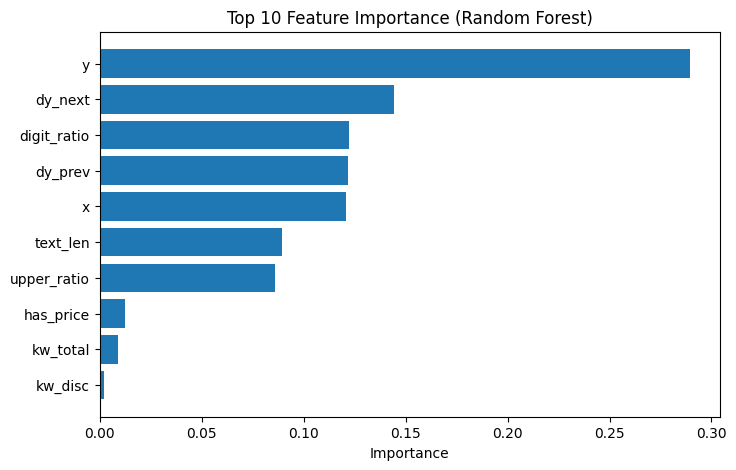

In [33]:
plt.figure(figsize=(8, 5))
plt.barh(
    feat_importance["feature"][:10][::-1],
    feat_importance["importance"][:10][::-1]
)
plt.title("Top 10 Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.show()


#### Insight: 
Analisis Feature Importance

Berdasarkan grafik Feature Importance, ditemukan beberapa pola menarik yang mendasari keputusan model:

1. Dominasi Posisi Geometris (y & x): Fitur y (posisi vertikal) adalah fitur terkuat dengan skor importance > 0.28. 
Ini menegaskan hipotesis bahwa struktur dokumen adalah sinyal utama; Header selalu berada di atas (nilai y rendah) dan Total/Footer di bawah (nilai y tinggi).

2. Peran Krusial Konteks Spasi (dy_next & dy_prev): Fitur dy_next (jarak ke baris berikutnya) menempati posisi kedua terpenting. 
Ini menunjukkan model memanfaatkan pola spasi (whitespace) untuk membedakan baris item (yang biasanya rapat/jarak kecil) dengan baris pemisah segmen (yang memiliki jarak lebih lebar).

3. Kandungan vs. Kata Kunci: Fitur digit_ratio (kepadatan angka) cukup signifikan, yang logis untuk mendeteksi baris harga atau item. Namun, fitur berbasis keyword spesifik (kw_total, kw_disc) memiliki kontribusi yang sangat kecil.

    * Interpretasi Positif: Rendahnya ketergantungan pada keyword justru baik, karena menandakan model mampu melakukan generalisasi. Model tidak akan gagal hanya karena struk menggunakan bahasa berbeda (misal: "Jumlah" vs "Total") atau singkatan yang tidak ada dalam kamus keyword.

Kesimpulan: Model Random Forest ini bekerja efektif sebagai Layout-Based Classifier, memprioritaskan "di mana teks berada" dan "bagaimana bentuknya" daripada "apa bacaannya secara harfiah".

#### Hasil Final
   Model yang akan digunakan sebagai item line belanja classifier adalah Random Forest
   karena model sudah di latih dengan dengan data lama dan di validasi dengan dataset baru yang belum pernah dilihat tanpa ada tambahan feature dan heyperparameter dan model telah dapat menujukan perbaikan recall dan menurukan fasle negatives pada validasi dataset. ini mengidikasikan kemapuan model untuk mengeneralisasi dengan baik



##### selanjutnya Gabungkan kedua datase (dataset lama dan baru = df dan df_new)
* Gabung dataset agar dataset lebih luas
* dan latih model dengan dataset ini dengan menggunakan algoritma Random Forest.
* simpan model dalam bentuk h5 atau pk1

In [36]:
# Gabungkan dataset
df_all = pd.concat([df, df_new], ignore_index=True)

# buat feature yang akan digunakan train model.
X_all = build_features(df_all)
y_all = df_all["is_item_line"].astype(int)

# definisikan model
rf_final = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=3,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# 
rf_final.fit(X_all, y_all)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",3
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [40]:
# simpan model 

joblib.dump(rf_final, "../model/rf_itemline_v1.pkl")


['../model/rf_itemline_v1.pkl']

In [41]:
# Simpan model dalam sebagai artifact untuk deployment
artifact = {
    "model": rf_final,
    "features": list(X_all.columns),
    "version": "v1"
}
joblib.dump(artifact, "../model/rf_itemline_bundle.pkl")


['../model/rf_itemline_bundle.pkl']